In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchmetrics import Accuracy, ConfusionMatrix
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, InterpolationMode

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from PIL import Image 
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split

import timm
from torchinfo import summary

In [5]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key = secret_value_0)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, \
          go to Add-ons -> Secrets and provide your W&B access token. \
          Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Exploratory Data Analysis**

In [6]:
df = pd.read_csv('../input/paddy-disease-classification/train.csv')
df.head(5)

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [7]:
def pie_chart(df, col = 'label', size = (20,7)):

    var = dict(df.groupby(col).size())
    palette_color = sns.color_palette('bright')
    fig = plt.figure(figsize = size)

    plt.pie(x = var.values(),
            labels = var.keys(), colors = palette_color,
            autopct='%.0f%%')

    plt.show()

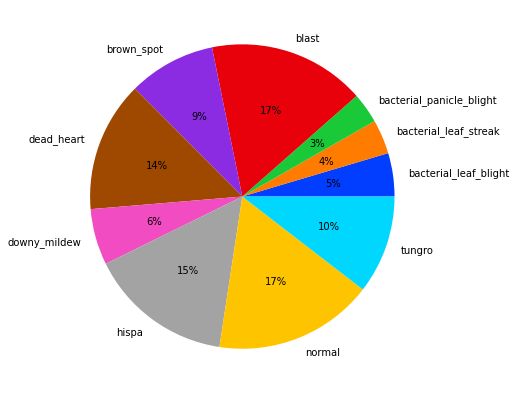

In [8]:
pie_chart(df)

<AxesSubplot:xlabel='variety', ylabel='count'>

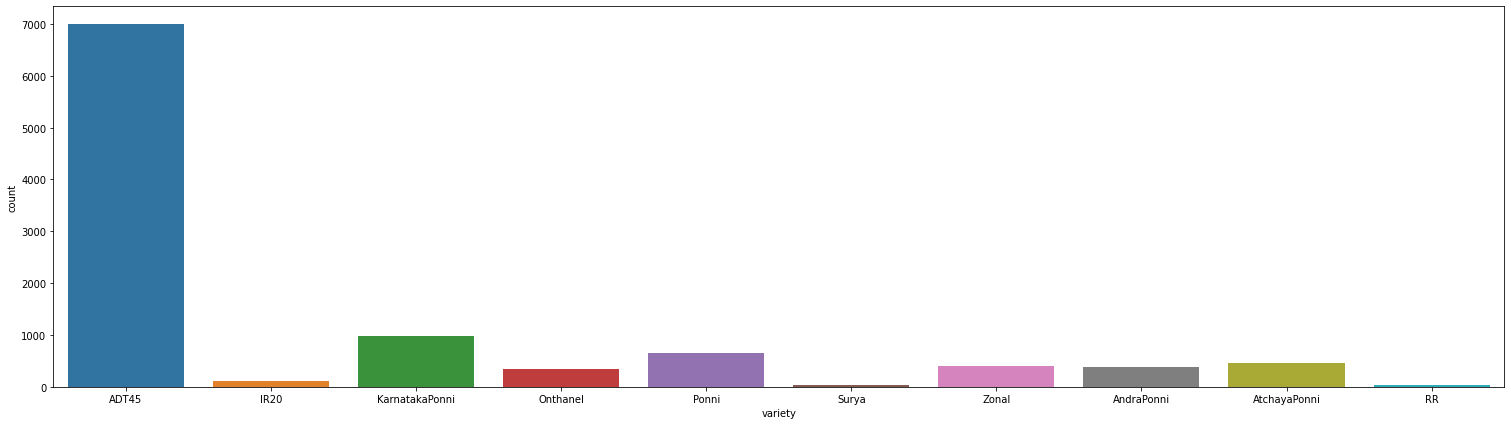

In [9]:
fig = plt.figure(figsize = (26,7))
sns.countplot(data = df, x = 'variety')

<AxesSubplot:xlabel='age', ylabel='count'>

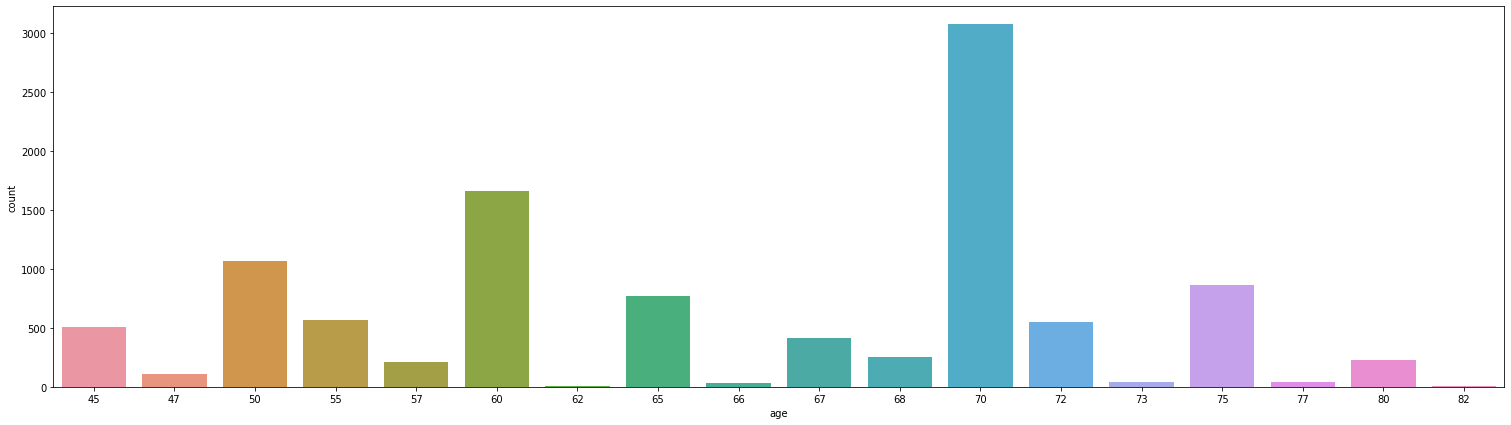

In [10]:
fig = plt.figure(figsize = (26,7))
sns.countplot(data = df, x = 'age')

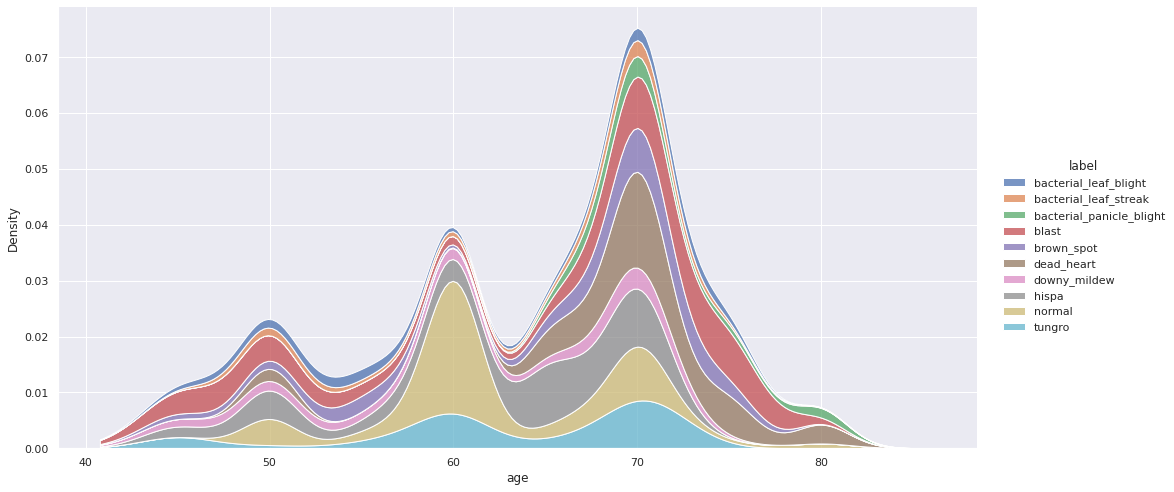

In [11]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.displot(df, x="age", hue="label", kind="kde", multiple="stack", height=7,  aspect=2)

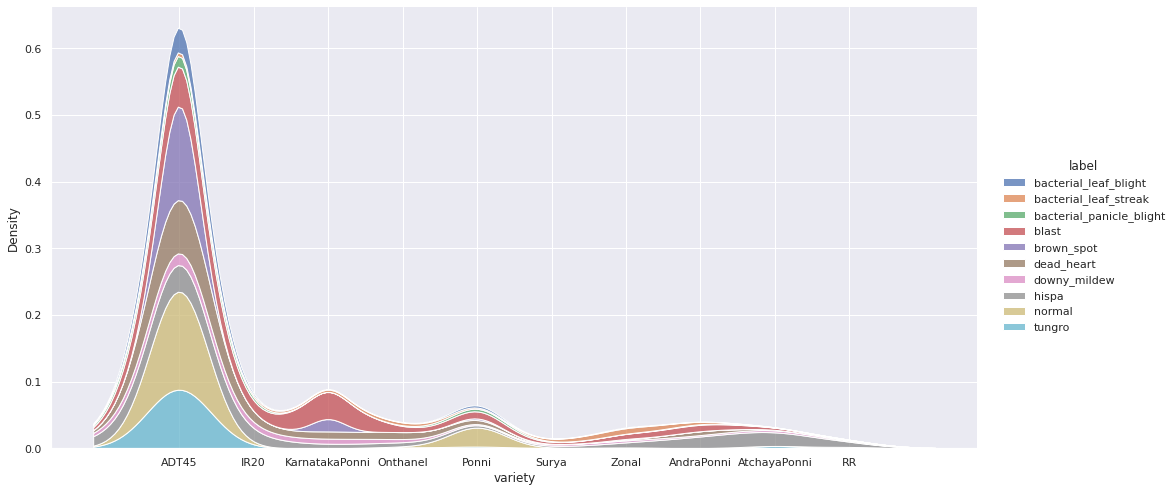

In [12]:
variety = list(df['variety'].unique())
variety_dict = {label: idx for idx, label in enumerate(df['variety'].unique())}
df['variety'] = df['variety'].map(variety_dict)

sns.set(rc={"figure.figsize":(8, 4)}) 
fig = sns.displot(df, x="variety", hue="label", kind="kde", multiple="stack", height=7,  aspect=2)
plt.xticks(range(0,len(variety)), variety)
plt.show(fig)

# Parameters and Hyperparameters

In [13]:
class CONFIG:
    df_path = '../input/paddy-disease-classification/train.csv'
    train_path = '../input/paddy-disease-classification/train_images'
    test_path = '../input/paddy-disease-classification/test_images'
    model_path = 'checkpoint/{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}'
    split = [0.8, 0.2]
    batch_size = 16
    weight_decay = 1e-4
    learning_rate = 1e-4
    lr_patience = 2
    stop_patience = 3
    layers = 2
    classes = 10
    gpus = (1 if torch.cuda.is_available() else 0)
    num_epochs = 15
    accum = 64
    num_workers = 2
    shuffle = False

In [14]:
df = pd.read_csv(CONFIG.df_path)

# Label Encoding

In [15]:
labelencoder = LabelEncoder()
df['label_name'] = df['label']
df['label'] = labelencoder.fit_transform(df['label'])
print('classes encoded:', labelencoder.classes_)
display(df.head(5))

classes encoded: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']


image_id  label variety  age             label_name
0  100330.jpg      0   ADT45   45  bacterial_leaf_blight
1  100365.jpg      0   ADT45   45  bacterial_leaf_blight
2  100382.jpg      0   ADT45   45  bacterial_leaf_blight
3  100632.jpg      0   ADT45   45  bacterial_leaf_blight
4  101918.jpg      0   ADT45   45  bacterial_leaf_blight

# Custom Dataset

In [16]:
class PaddyImageDataset(Dataset):
    
    def __init__(self, 
                 df = None, 
                 root_dir = None, 
                 transform = None):

        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
        if df is not None:
            self.imgs = self.df["image_id"]
            self.labels = self.df["label"]

        
    def __len__(self):
        
        if self.df is not None:
            return len(self.df)
        else:
            return len(os.listdir(self.root_dir))
    
    def __getitem__(self, index):

        if self.df is not None:
            img_id = self.imgs[index]
            img_label = self.labels[index]
            img_label_name = self.df['label_name'][index]
            
            img_path = os.path.join(
                self.root_dir, img_label_name, img_id)
            
            with Image.open(img_path).convert('RGB') as image:               
                if self.transform is not None:
                    img = self.transform(image)
                    
            return img, torch.tensor(int(img_label))

        else:
            
            img_id = os.listdir(self.root_dir)[index]
            img_path = os.path.join(self.root_dir, img_id)
            
            with Image.open(
                os.path.join(img_path)).convert('RGB') as image:               
                if self.transform is not None:
                    img = self.transform(image)
                            
            return img

# WeightedRandomSamplers

In [17]:
def getWeightedRandomSampler(df):
    
    counts = np.bincount(df['label'])
    label_weights = 1. / counts
    weights = label_weights[df['label']]
    
    return WeightedRandomSampler(
        weights, num_samples = len(weights), replacement = True)

# Data Loaders

In [18]:
def get_loader(dataset, batch_size, sampler = None):
    
    loader = DataLoader(
            dataset, batch_size = batch_size)
    
    if sampler is not None:
        loader.__dict__['sampler'] = sampler
    
    return loader

In [19]:
df_train, df_val = train_test_split(
    df, stratify = df[['label', 'variety']], 
    test_size = (1.0 - CONFIG.split[0]), 
    random_state = 42)

df_train.reset_index(inplace = True)
df_val.reset_index(inplace = True)

In [20]:
display(df_train.head(5))
df_val.head(5)

index    image_id  label variety  age  label_name
0   9422  102778.jpg      9   ADT45   57      tungro
1   8797  106299.jpg      8   ADT45   70      normal
2   9301  100155.jpg      8      RR   70      normal
3   3468  105182.jpg      4   ADT45   70  brown_spot
4   1210  102090.jpg      3   ADT45   45       blast

index    image_id  label   variety  age label_name
0   7487  107416.jpg      7     Ponni   60      hispa
1   6690  106765.jpg      7     ADT45   70      hispa
2   6558  101295.jpg      7     ADT45   70      hispa
3   7384  100546.jpg      7  Onthanel   70      hispa
4   8572  107267.jpg      8     ADT45   67     normal

In [21]:
train_sampler = getWeightedRandomSampler(df_train)
val_sampler = getWeightedRandomSampler(df_val)

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])])

# AutoAugmentation

In [23]:
autoaugment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.AutoAugment(
        policy = AutoAugmentPolicy.IMAGENET, 
        interpolation = InterpolationMode.BILINEAR,),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])])

In [24]:
train_dataset = PaddyImageDataset(
    root_dir = CONFIG.train_path, 
    df = df_train, 
    transform = autoaugment)

print('Length of train dataset:', len(train_dataset))

val_dataset = PaddyImageDataset(
    root_dir = CONFIG.train_path, 
    df = df_val, 
    transform = autoaugment)

print('Length of val dataset:', len(val_dataset))

predict_dataset = PaddyImageDataset(
    root_dir = CONFIG.test_path, 
    transform = transform)

print('Length of predict dataset:', len(predict_dataset))

Length of train dataset: 8325
Length of val dataset: 2082
Length of predict dataset: 3469


In [25]:
train_dataloader = get_loader(
    dataset = train_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = train_sampler)

val_dataloader = get_loader(
    dataset = val_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = val_sampler)

predict_dataloader = get_loader(
    dataset = predict_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = None)

# Data Visualization

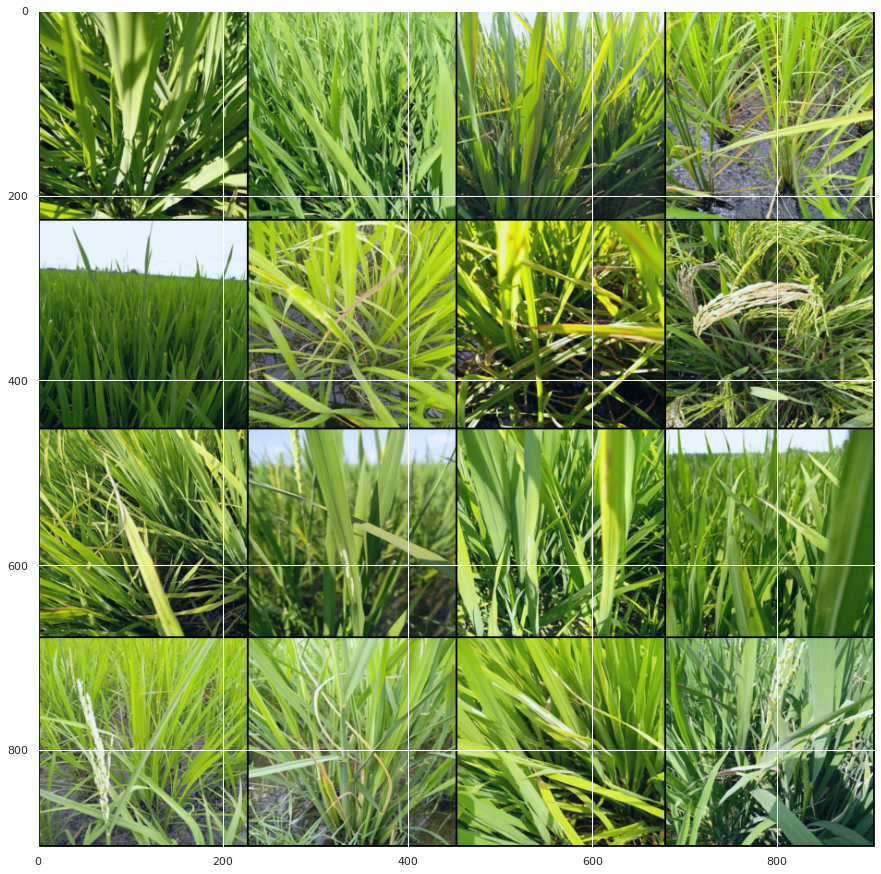

In [26]:
batch = next(iter(predict_dataloader))

grid_img = make_grid(
    batch, 
    nrow = 4,
    normalize = True)

plt.figure(figsize = (15,30))
plt.imshow(grid_img.permute(1, 2, 0))

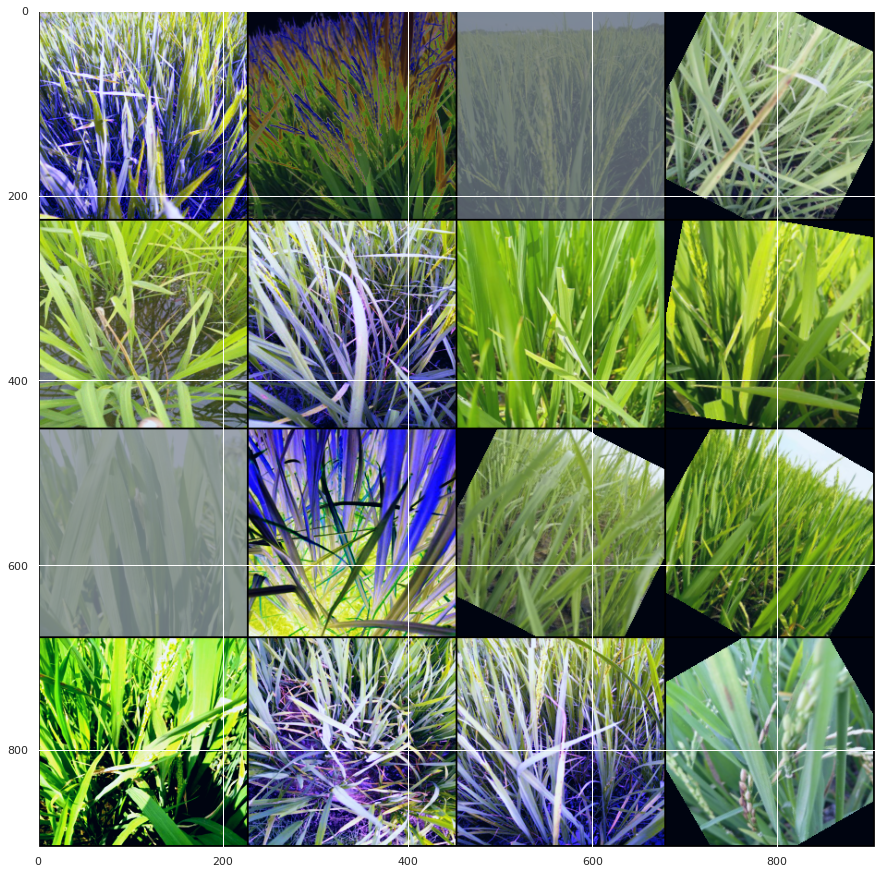

In [27]:
batch = next(iter(train_dataloader))

grid_img = make_grid(
    batch[0], 
    nrow = 4,
    normalize = True)

plt.figure(figsize = (15,30))
plt.imshow(grid_img.permute(1, 2, 0))

# Lightning Model

In [28]:
class PaddyDiseaseClassification(pl.LightningModule):


    def __init__(self,
                learning_rate,
                weight_decay,
                layers,
                patience,
                pretrained = True,
                classes = 10):

        super(PaddyDiseaseClassification, self).__init__()


        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.layers = layers
        self.patience = patience

        self.pretrained = pretrained
        self.classes = classes
        
        self.model = timm.create_model(
            "swin_base_patch4_window7_224_in22k", 
            pretrained = pretrained)
        
        self.model.head = nn.Linear(
            self.model.head.in_features, classes)

        self.save_hyperparameters()

        self.loss = nn.CrossEntropyLoss()

        self.train_acc = Accuracy(num_classes = classes)
        self.val_acc = Accuracy(num_classes = classes)
        
        self.finetune()
        
    def finetune(self):

        for param in list(self.model.children())[:-1]:
            for p in param.parameters():
                p.requires_grad = False
    
        for param in list(self.model.layers._modules['3'].blocks):
            for p in param.parameters():
                p.requires_grad = True

        if self.layers is not 0:
            for param in list(self.model.layers._modules['2'].blocks)[-self.layers:]:
                for p in param.parameters():
                    p.requires_grad = True


    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr = self.learning_rate, 
            weight_decay = self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode = 'max', 
            factor = 0.2, 
            patience = self.patience, 
            verbose = True)

        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_acc' 
       }

    
    def forward(self, images):
        
        output = self.model(images)
        return output
        

    def training_step(self, batch, batch_idx):

        images, labels = batch

        output = self.model(images)
        train_loss = self.loss(output, labels)

        self.log(
            name = 'train_loss',
            value = train_loss,
            on_step = False,
            on_epoch = True,
            prog_bar = True)

        train_acc = self.train_acc(output, labels)
        
        self.log(
            name = "train_acc",
            value = train_acc,
            on_step = False,
            on_epoch = True,
            prog_bar = True)

        return train_loss


    def validation_step(self, batch, batch_idx):

        images, labels = batch
        
        output = self.model(images)
        val_loss = self.loss(output, labels)

        val_acc = self.val_acc(output, labels)

        return {'val_loss': val_loss,
                'val_acc':val_acc,
                'log': {'val_loss': val_loss}}

    def validation_epoch_end(self, outputs):

        loss = torch.stack([o['val_loss'] for o in outputs], 0).mean()
        acc = torch.stack([o['val_acc'] for o in outputs], 0).mean()

        out = {'val_loss': loss,
               'val_acc': acc}

        self.log(
            name = 'val_loss',
            value = loss,
            on_epoch = True,
            prog_bar = True)

        self.log(
            name = 'val_acc',
            value = acc,
            on_epoch = True,
            prog_bar = True)

        return {**out, 'log': out}
    
    

# Model Training

In [29]:
model = PaddyDiseaseClassification(
    learning_rate = CONFIG.learning_rate,
    weight_decay = CONFIG.weight_decay,
    layers = CONFIG.layers,
    patience = CONFIG.lr_patience,
    classes = CONFIG.classes)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth


In [30]:
summary(
    model, 
    input_size = (16, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
PaddyDiseaseClassification                              [16, 10]                  --
├─SwinTransformer: 1-1                                  [16, 10]                  12,298
│    └─PatchEmbed: 2-1                                  [16, 3136, 128]           --
│    │    └─Conv2d: 3-1                                 [16, 128, 56, 56]         (6,272)
│    │    └─LayerNorm: 3-2                              [16, 3136, 128]           (256)
│    └─Dropout: 2-2                                     [16, 3136, 128]           --
│    └─Sequential: 2-3                                  [16, 49, 1024]            --
│    │    └─BasicLayer: 3-3                             [16, 784, 256]            (529,992)
│    │    └─BasicLayer: 3-4                             [16, 196, 512]            (2,108,560)
│    │    └─BasicLayer: 3-5                             [16, 49, 1024]            58,892,832
│    │    └─BasicLayer: 

In [31]:
early_stop_callback = EarlyStopping(
                        monitor = "val_acc",
                        min_delta = 0.00,
                        patience = CONFIG.stop_patience,
                        verbose = False,
                        mode = "max")

model_checkpoint = ModelCheckpoint(
                        monitor = 'val_acc',
                        save_top_k = 1,
                        save_weights_only = True,
                        filename = CONFIG.model_path,
                        verbose = False,
                        mode = 'max')

logger = WandbLogger(project = "swin-vit-model")

wandb: Currently logged in as: yegi (yegi-ml). Use `wandb login --relogin` to force relogin


In [32]:
trainer = Trainer(
    auto_lr_find = True,
    gpus = CONFIG.gpus,
    max_epochs = CONFIG.num_epochs,
    accumulate_grad_batches = CONFIG.accum,
    logger = logger,
    callbacks = [model_checkpoint, 
                 early_stop_callback])

In [33]:
trainer.fit(
    model = model, 
    train_dataloaders = train_dataloader, 
    val_dataloaders = val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Model Inference

In [34]:
predictions = trainer.predict(
    model = model, dataloaders = predict_dataloader)

Predicting: 521it [00:00, ?it/s]

In [35]:
flag = True
for tensor in predictions:
    if flag == True:
        stack = tensor
        flag = False
    else:
        stack = torch.concat(
            [stack,tensor], axis = 0)

In [36]:
submission = pd.DataFrame()
submission['image_id'] = pd.DataFrame(os.listdir(CONFIG.test_path))
submission['label'] = pd.DataFrame(np.argmax(stack, axis = 1).numpy().astype('int'))

In [37]:
submission['label'] = labelencoder.inverse_transform(submission['label'])
submission.head(10)

image_id                  label
0  200607.jpg                 normal
1  202733.jpg                 normal
2  200207.jpg  bacterial_leaf_streak
3  203024.jpg                 tungro
4  203056.jpg                  hispa
5  202751.jpg                  blast
6  201191.jpg                  blast
7  200912.jpg             dead_heart
8  200067.jpg                  blast
9  201689.jpg                  hispa

In [38]:
submission.to_csv('submission.csv', index = False)